In [46]:
%matplotlib inline
import pandas as pd
import MySQLdb
from matplotlib import pyplot as plt

In [26]:
ci_projects = pd.read_csv("longer2y_and_more24pr_withci.csv")

ci_projects.head()

,Id,Slug,Url,HasTravis,HasCircle
0,3670016,seomoz/qless-py,https://api.github.com/repos/seomoz/qless-py,True,False
1,18814208,rdkit/conda-rdkit,https://api.github.com/repos/rdkit/conda-rdkit,False,False
2,37952512,NCAR/mizuRoute,https://api.github.com/repos/NCAR/mizuRoute,False,False
3,1319936,kazuho/picojson,https://api.github.com/repos/kazuho/picojson,True,False
4,6761984,IATI/IATI-Schemas,https://api.github.com/repos/IATI/IATI-Schemas,True,False


In [27]:
all_proj = len(ci_projects)
no_ci = len(ci_projects.loc[(ci_projects["HasTravis"] == False) & (ci_projects["HasCircle"] == False)])
one_ci = len(ci_projects.loc[(ci_projects["HasTravis"] == True) | (ci_projects["HasCircle"] == True)])
both_ci = len(ci_projects.loc[(ci_projects["HasTravis"] == True) & (ci_projects["HasCircle"] == True)])

In [28]:
print("Out of {} projects, {} have no CI, {} have at least one CI, and {} both use Travis and Circle".format(all_proj, no_ci, one_ci, both_ci))

Out of 89481 projects, 40651 have no CI, 48830 have at least one CI, and 856 both use Travis and Circle


In [29]:
travis_proj = len(ci_projects.loc[(ci_projects["HasTravis"] == True)])
circle_proj = len(ci_projects.loc[(ci_projects["HasCircle"] == True)])

In [30]:
print("Out of {} projects that use CI, {} use Travis and {} use Circle".format(one_ci, travis_proj, circle_proj))

Out of 48830 projects that use CI, 45881 use Travis and 3805 use Circle


In [40]:
db = MySQLdb.connect(passwd="ghtorrent_restore",db="ghtorrent_06_19",user="ghtorrent")

c = db.cursor()

ci_projects["NumComments"] = 0

base_query = """select total_number_pr_comments, total_number_prs 
        from projects pr, users us 
        where pr.owner_id = us.id and pr.name = '{}' and us.login= '{}'
        """

def update_num_prs(row):
    if row.HasTravis or row.HasCircle:
        query = base_query.format(row.Slug.split("/")[1], row.Slug.split("/")[0])
        
        c.execute(query)
        
        res = c.fetchone()
        
        if res is None:
            return None
        
        return res[1]
    return 0
    
    
def update_num_prs_comments(row):
    if row.HasTravis or row.HasCircle:
        query = base_query.format(row.Slug.split("/")[1], row.Slug.split("/")[0])
        
        c.execute(query)
        
        res = c.fetchone()
        
        if res is None:
            return None
        
        return res[0]
    return 0

#ci_projects["NumPrs"] = ci_projects.apply(update_num_prs, axis = 1)
ci_projects["NumComments"] = ci_projects.apply(update_num_prs_comments, axis = 1)

ci_projects.head()

,Id,Slug,Url,HasTravis,HasCircle,NumPrs,NumComments
0,3670016,seomoz/qless-py,https://api.github.com/repos/seomoz/qless-py,True,False,35.0,59.0
1,18814208,rdkit/conda-rdkit,https://api.github.com/repos/rdkit/conda-rdkit,False,False,0.0,0.0
2,37952512,NCAR/mizuRoute,https://api.github.com/repos/NCAR/mizuRoute,False,False,0.0,0.0
3,1319936,kazuho/picojson,https://api.github.com/repos/kazuho/picojson,True,False,67.0,107.0
4,6761984,IATI/IATI-Schemas,https://api.github.com/repos/IATI/IATI-Schemas,True,False,109.0,79.0


There are 48800 projects with ci and with at least 25 PRs


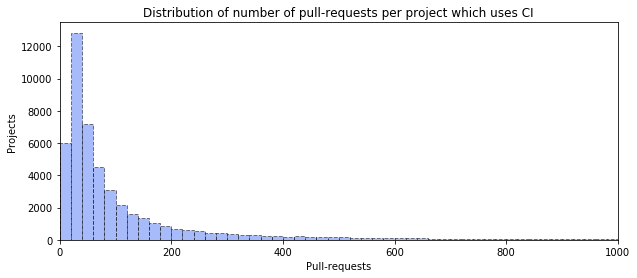

In [60]:
has_ci_projects = ci_projects.loc[((ci_projects["HasTravis"]) | (ci_projects["HasCircle"])) & (ci_projects["NumPrs"] > -1)]

print("There are {} projects with ci and with at least 25 PRs".format(len(has_ci_projects)))

plt.figure(figsize=(10, 4))

plt.hist(has_ci_projects["NumPrs"], bins = 50, color='#5177f5', alpha=0.5, range=(0,1000), ls='dashed', edgecolor='black')
#plt.legend(loc='upper right')

plt.xlim(0, 1000)

plt.title("Distribution of number of pull-requests per project which uses CI")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

plt.show()

In [65]:
has_circle_and_comments = has_ci_projects.loc[(has_ci_projects["HasTravis"] == False) & (has_ci_projects["HasCircle"] == True)]

has_circle_and_comments.to_csv("circle_projects_to_scrape.csv")